In [1]:
# Debug script to test the rolling ball implementation
import numpy as np
import time
from pathlib import Path
import sys

# Add the project root to Python path
project_root = Path("/users/PAS2598/duarte63/GitHub/perinuclear_analysis")
sys.path.insert(0, str(project_root))

# Import the background subtractor
from perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor import BackgroundSubtractor

# Test with a small synthetic image first
print("Creating small test image...")
test_image = np.random.random((5, 100, 100)).astype(np.float32) * 1000
print(f"Test image shape: {test_image.shape}")

# Initialize background subtractor
bg_subtractor = BackgroundSubtractor(use_cuda=False)  # Force CPU for debugging

print("Testing rolling ball with small radius...")
start_time = time.time()

try:
    corrected_img, metadata = bg_subtractor.subtract_background(
        image=test_image,
        channel_name="test",
        pixel_size=0.1,
        method='rolling_ball',
        radius=10,  # Small radius
        light_background=False
    )
    
    elapsed_time = time.time() - start_time
    print(f"✅ Success! Processing time: {elapsed_time:.2f}s")
    print(f"Method used: {metadata['method']}")
    print(f"Result shape: {corrected_img.shape}")
    
except Exception as e:
    elapsed_time = time.time() - start_time
    print(f"❌ Error after {elapsed_time:.2f}s: {e}")
    import traceback
    traceback.print_exc()

/users/PAS2598/duarte63/GitHub/perinuclear_analysis/perinuclear_analysis/__init__.py:41: UserWarning: MIPPreprocessor not available yet
  warnings.warn("MIPPreprocessor not available yet")
/users/PAS2598/duarte63/GitHub/perinuclear_analysis/perinuclear_analysis/__init__.py:61: UserWarning: Phase 4 dependencies not installed: No module named 'perinuclear_analysis.ring_analysis'
Install with: pip install .[phase4]
  warnings.warn(
/users/PAS2598/duarte63/GitHub/perinuclear_analysis/perinuclear_analysis/__init__.py:74: UserWarning: Phase 5 dependencies not installed: No module named 'perinuclear_analysis.signal_quantification'
Install with: pip install .[phase5]
  warnings.warn(


Creating small test image...
Test image shape: (5, 100, 100)
Testing rolling ball with small radius...
✅ Success! Processing time: 11.45s
Method used: rolling_ball_cuda
Result shape: (5, 100, 100)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from pathlib import Path
import tifffile
import sys

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Add the project root to Python path
project_root = Path("/users/PAS2598/duarte63/GitHub/perinuclear_analysis")
sys.path.insert(0, str(project_root))

# Import the background subtractor

from perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor import BackgroundSubtractor
from perinuclear_analysis.data_processing import ImageLoader

# Check CUDA setup
import cupy as cp
print(f"✅ CuPy version: {cp.__version__}")
print(f"✅ CUDA version: {cp.cuda.runtime.runtimeGetVersion()}")
print(f"✅ GPU count: {cp.cuda.runtime.getDeviceCount()}")


✅ CuPy version: 13.4.1
✅ CUDA version: 12080
✅ GPU count: 1


In [3]:
# Load your real microscopy data using ImageLoader
image_path = Path("/fs/scratch/PAS2598/duarte63/ALIX_confocal_data/ALIX/nd2/anti_ALIX_15_min_1.ome.tiff")

print(f"Loading image from: {image_path}")
print(f"File exists: {image_path.exists()}")

if image_path.exists():
    # Initialize ImageLoader
    image_loader = ImageLoader()
    
    # Load the image (returns only the image data)
    loaded_data = image_loader.load_image(image_path)
    
    # Get metadata from the ImageLoader instance
    metadata = {
        'pixel_size_um': image_loader.get_pixel_size(),
        'channel_names': image_loader.get_channel_names(),
        'image_info': image_loader.get_image_info(loaded_data)
    }
    
    print(f"✅ Image loaded successfully!")
    print(f"   Shape: {loaded_data.shape}")
    print(f"   Data type: {loaded_data.dtype}")
    print(f"   Value range: [{loaded_data.min():.1f}, {loaded_data.max():.1f}]")
    print(f"   Memory usage: {loaded_data.nbytes / 1024**2:.1f} MB")
    
    # Get channel information
    channel_names = image_loader.get_channel_names()
    pixel_size = image_loader.get_pixel_size()
    
    print(f"   Channel names: {channel_names}")
    print(f"   Pixel size: {pixel_size} μm")
    print(f"   Number of channels: {len(channel_names)}")
    
    # Convert to float32 if needed
    if loaded_data.dtype != np.float32:
        loaded_data = loaded_data.astype(np.float32)
        print("   Converted to float32")
        
else:
    print("❌ Image file not found!")

INFO: Loaded metadata from converted TIFF: pixel_size=0.108333333333333μm


Loading image from: /fs/scratch/PAS2598/duarte63/ALIX_confocal_data/ALIX/nd2/anti_ALIX_15_min_1.ome.tiff
File exists: True


INFO: Successfully loaded TIFF image with shape: (23, 1800, 1800, 4)


✅ Image loaded successfully!
   Shape: (23, 1800, 1800, 4)
   Data type: uint16
   Value range: [33.0, 3609.0]
   Memory usage: 568.5 MB
   Channel names: ['AF647', 'AF568', 'AF488', 'DAPI']
   Pixel size: 0.108333333333333 μm
   Number of channels: 4
   Converted to float32


In [15]:
new_channel_names = ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']  # Adjust based on your data
image_loader.rename_channels(new_channel_names)

# Initialize with CUDA acceleration
bg_subtractor = BackgroundSubtractor()
print(type(bg_subtractor))
# Check GPU info

INFO: Renamed channels to: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']
INFO: Initializing CUDA-accelerated background subtractor (CUDA required)
INFO: GPU Memory: 39.0GB free / 39.4GB total


<class 'perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor.BackgroundSubtractor'>


In [16]:
channel_names = image_loader.get_channel_names()
print(channel_names)

['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


In [17]:
# Process each channel with the FULL z-stack (not just middle slice)
results = {}

for i, channel_name in enumerate(channel_names):
    print(f"\nProcessing {channel_name}...")
    
    # Extract the FULL channel data (all z-slices)
    channel_data = loaded_data[:, :, :, i]  # Shape: (Z, Y, X)
    
    # Define specific parameters for each channel
    if channel_name == "DAPI":
        params = {
            'method': 'rolling_ball',
            'radius': 150,
            'light_background': False
        }
    elif channel_name == "Phalloidin":
        params = {
            'method': 'rolling_ball',
            'radius': 100,
            'light_background': False
        }
    else:
        params = {
            'method': 'rolling_ball',
            'radius': 75,
            'light_background': False
        }
    
    # Process with specific parameters
    corrected_img, metadata = bg_subtractor.subtract_background(
        image=channel_data,
        channel_name=channel_name,
        pixel_size=pixel_size,
        **params
    )
    
    results[channel_name] = (corrected_img, metadata)
    print(f"{channel_name}: {corrected_img.shape}, method={metadata['method']}")
    print(f"   GPU accelerated: {metadata.get('gpu_accelerated', False)}")
    print(f"   Processing time: {metadata.get('processing_time_seconds', 'N/A')}s")

print("\nAll channels processed successfully!")

INFO: Applying CUDA rolling_ball background subtraction to 3D image (23, 1800, 1800)



Processing LAMP1...


INFO: Processing 23 z-slices with CUDA rolling ball approximation (radius=75)
INFO: Applying CUDA rolling_ball background subtraction to 3D image (23, 1800, 1800)
INFO: Processing 23 z-slices with CUDA rolling ball approximation (radius=100)


LAMP1: (23, 1800, 1800), method=rolling_ball_cuda
   GPU accelerated: True
   Processing time: N/As

Processing Phalloidin...


INFO: Applying CUDA rolling_ball background subtraction to 3D image (23, 1800, 1800)
INFO: Processing 23 z-slices with CUDA rolling ball approximation (radius=75)


Phalloidin: (23, 1800, 1800), method=rolling_ball_cuda
   GPU accelerated: True
   Processing time: N/As

Processing ALIX...


INFO: Applying CUDA rolling_ball background subtraction to 3D image (23, 1800, 1800)
INFO: Processing 23 z-slices with CUDA rolling ball approximation (radius=150)


ALIX: (23, 1800, 1800), method=rolling_ball_cuda
   GPU accelerated: True
   Processing time: N/As

Processing DAPI...
DAPI: (23, 1800, 1800), method=rolling_ball_cuda
   GPU accelerated: True
   Processing time: N/As

All channels processed successfully!


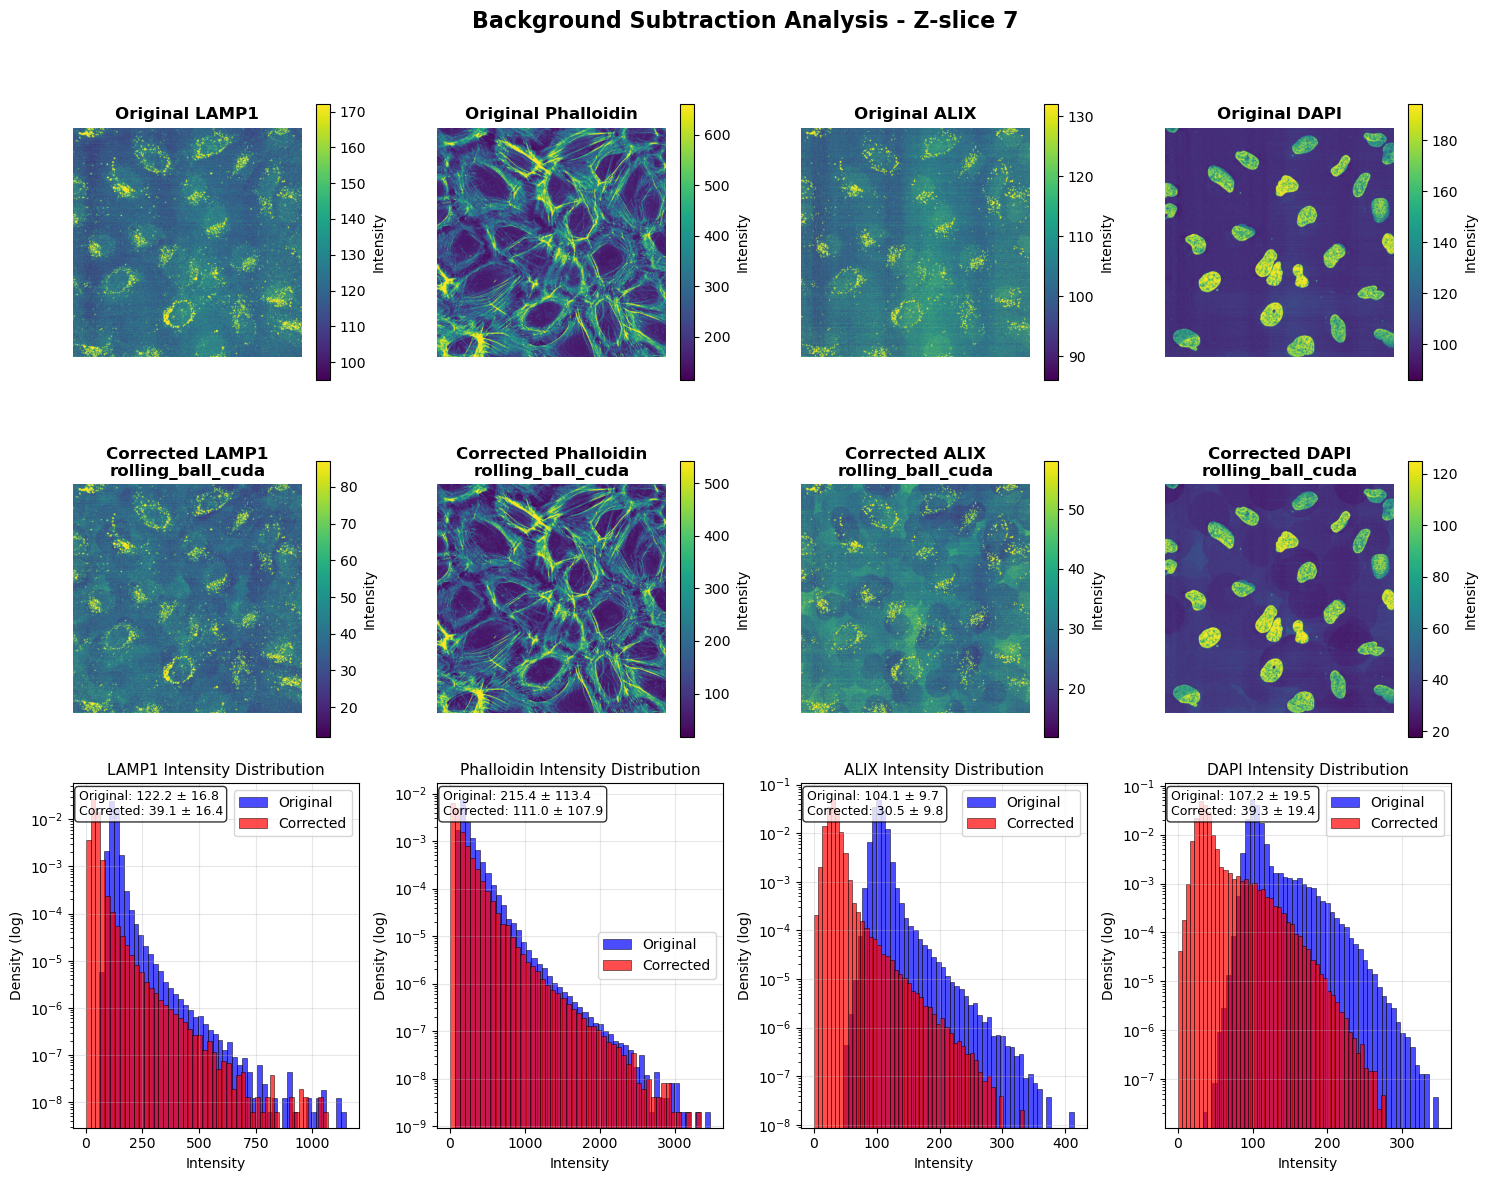

In [21]:
# Refresh channel names after any rename
channel_names = image_loader.get_channel_names()

# Middle slice index
middle_slice_idx = loaded_data.shape[0] // 3  # Z dimension

# Plot middle slice only for each channel
fig = bg_subtractor.plot_background_subtraction_comparison(
    original_data=loaded_data,         # shape: (Z, Y, X, C)
    corrected_results=results,         # dict: {channel_name: (corrected_3d, metadata)}
    channel_names=channel_names,       # list must align with results keys
    z_slice=middle_slice_idx,          # middle slice only
    figsize=(15, 12)
)
plt.show()